# Evaluate ALL features

Similar to notebook 3 but we package everything inside a for loop to evaluate all the features.

In [20]:
# TO REMOVE when notebook is stable

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Common Imports

### Decide how to filter the anndata object

In [10]:
from anndata import read_h5ad
from tissue_purifier.genex import *

In [11]:
# filter cells parameters
fc_bc_min_umi = 200                  # filter cells with too few UMI
fc_bc_max_umi = 3000                 # filter cells with too many UMI
fc_bc_min_n_genes_by_counts = 10     # filter cells with too few GENES
fc_bc_max_n_genes_by_counts = 2500   # filter cells with too many GENES
fc_bc_max_pct_counts_mt = 5          # filter cells with mitocrondial fraction too high

# filter genes parameters
fg_bc_min_cells_by_counts = 3000      # filter genes which appear in too few CELLS

# filter rare cell types parameters
fctype_bc_min_cells_absolute = 100   # filter cell-types which are too RARE in absolute number
fctype_bc_min_cells_frequency = 0.01 # filter cell-types which are too RARE in relative abundance

### Open the first annotated anndata 

In [12]:
adata = read_h5ad(filename="./testis_anndata_annotated/anndata_sick3.h5ad")
adata

AnnData object with n_obs × n_vars = 33441 × 23514
    obs: 'x', 'y', 'cell_type'
    obsm: 'barlow', 'dino', 'ncv_k10', 'ncv_k100', 'ncv_k20', 'ncv_k200', 'ncv_k50', 'ncv_k500', 'simclr', 'vae'

### compute few metrics

In [13]:
import scanpy as sc
cell_type_key = "cell_type"

# mitocondria metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# counts cells frequency
tmp = adata.obs[cell_type_key].values.describe()
print(tmp)
mask1 = (tmp["counts"] > fctype_bc_min_cells_absolute)
mask2 = (tmp["freqs"] > fctype_bc_min_cells_frequency)
mask = mask1 * mask2
cell_type_keep = set(tmp[mask].index.values)
adata.obs["keep_ctype"] = adata.obs["cell_type"].apply(lambda x: x in cell_type_keep)

# Note that adata has extra annotation now
adata

             counts     freqs
categories                   
ES            12552  0.375348
Endothelial     417  0.012470
Leydig          340  0.010167
Macrophage      623  0.018630
Myoid           969  0.028976
RS             6780  0.202745
SPC            8069  0.241291
SPG            2238  0.066924
Sertoli        1453  0.043450


AnnData object with n_obs × n_vars = 33441 × 23514
    obs: 'x', 'y', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'keep_ctype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'barlow', 'dino', 'ncv_k10', 'ncv_k100', 'ncv_k20', 'ncv_k200', 'ncv_k50', 'ncv_k500', 'simclr', 'vae'

### Filter out cells, genes and cell-type

In [14]:
adata = adata[adata.obs["total_counts"] > fc_bc_min_umi, :] 
adata = adata[adata.obs["total_counts"] < fc_bc_max_umi, :] 
adata = adata[adata.obs["n_genes_by_counts"] > fc_bc_min_n_genes_by_counts, :] 
adata = adata[adata.obs["n_genes_by_counts"] < fc_bc_max_n_genes_by_counts, :] 
adata = adata[adata.obs["pct_counts_mt"] < fc_bc_max_pct_counts_mt, :]
adata = adata[adata.obs["keep_ctype"] == True, :]
adata = adata[:, adata.var["n_cells_by_counts"] > fg_bc_min_cells_by_counts]

# Loop to train multiple gene_regression models

In [20]:
from tissue_purifier.genex import *
import os
import numpy
import matplotlib
import matplotlib.pyplot as plt
import seaborn

In [15]:
gr_ckpt_dir = "gr_ckpt"
filename_no_covariate = os.path.join(gr_ckpt_dir, "gr_no_covariate.pt")

ckpt_list, dataset_list = [], []
for f in os.listdir(gr_ckpt_dir):
    if not f.endswith("no_covariate.pt") and not f.endswith("dataset.pt"):
        ckpt_list.append(f)
    if f.endswith("dataset.pt"):
        dataset_list.append(f)

dataset_list.sort()
ckpt_list.sort()

for a,b in zip(dataset_list, ckpt_list):
    print(a, "--->", b)

gr_barlow_dataset.pt ---> gr_barlow_l2_0.01.pt
gr_dino_dataset.pt ---> gr_barlow_l2_0.1.pt
gr_ncv_k100_dataset.pt ---> gr_barlow_l2_1.0.pt
gr_ncv_k10_dataset.pt ---> gr_barlow_l2_10.0.pt
gr_ncv_k200_dataset.pt ---> gr_barlow_l2_None.pt
gr_ncv_k20_dataset.pt ---> gr_dino_l2_0.01.pt
gr_ncv_k500_dataset.pt ---> gr_dino_l2_0.1.pt
gr_ncv_k50_dataset.pt ---> gr_dino_l2_1.0.pt
gr_no_covariate_dataset.pt ---> gr_dino_l2_10.0.pt
gr_simclr_dataset.pt ---> gr_dino_l2_None.pt


# check the loss functions

In [ ]:
gr = GeneRegression()

nmax = len(ckpt_list)
ncols = 4
nrows = int(numpy.ceil(float(nmax)/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 6*nrows))
fig.suptitle("Loss History")

for n, ckpt_file in enumerate(ckpt_list):
    r,c = n//ncols, n%ncols
    ax_cur = axes[r,c]
    gr.load_ckpt(os.path.join(gr_ckpt_dir, ckpt_file))
    gr.show_loss(ax=ax_cur, logy=False, logx=False)
    _ = ax_cur.set_title(ckpt_file)

### check the overdispersion parameter

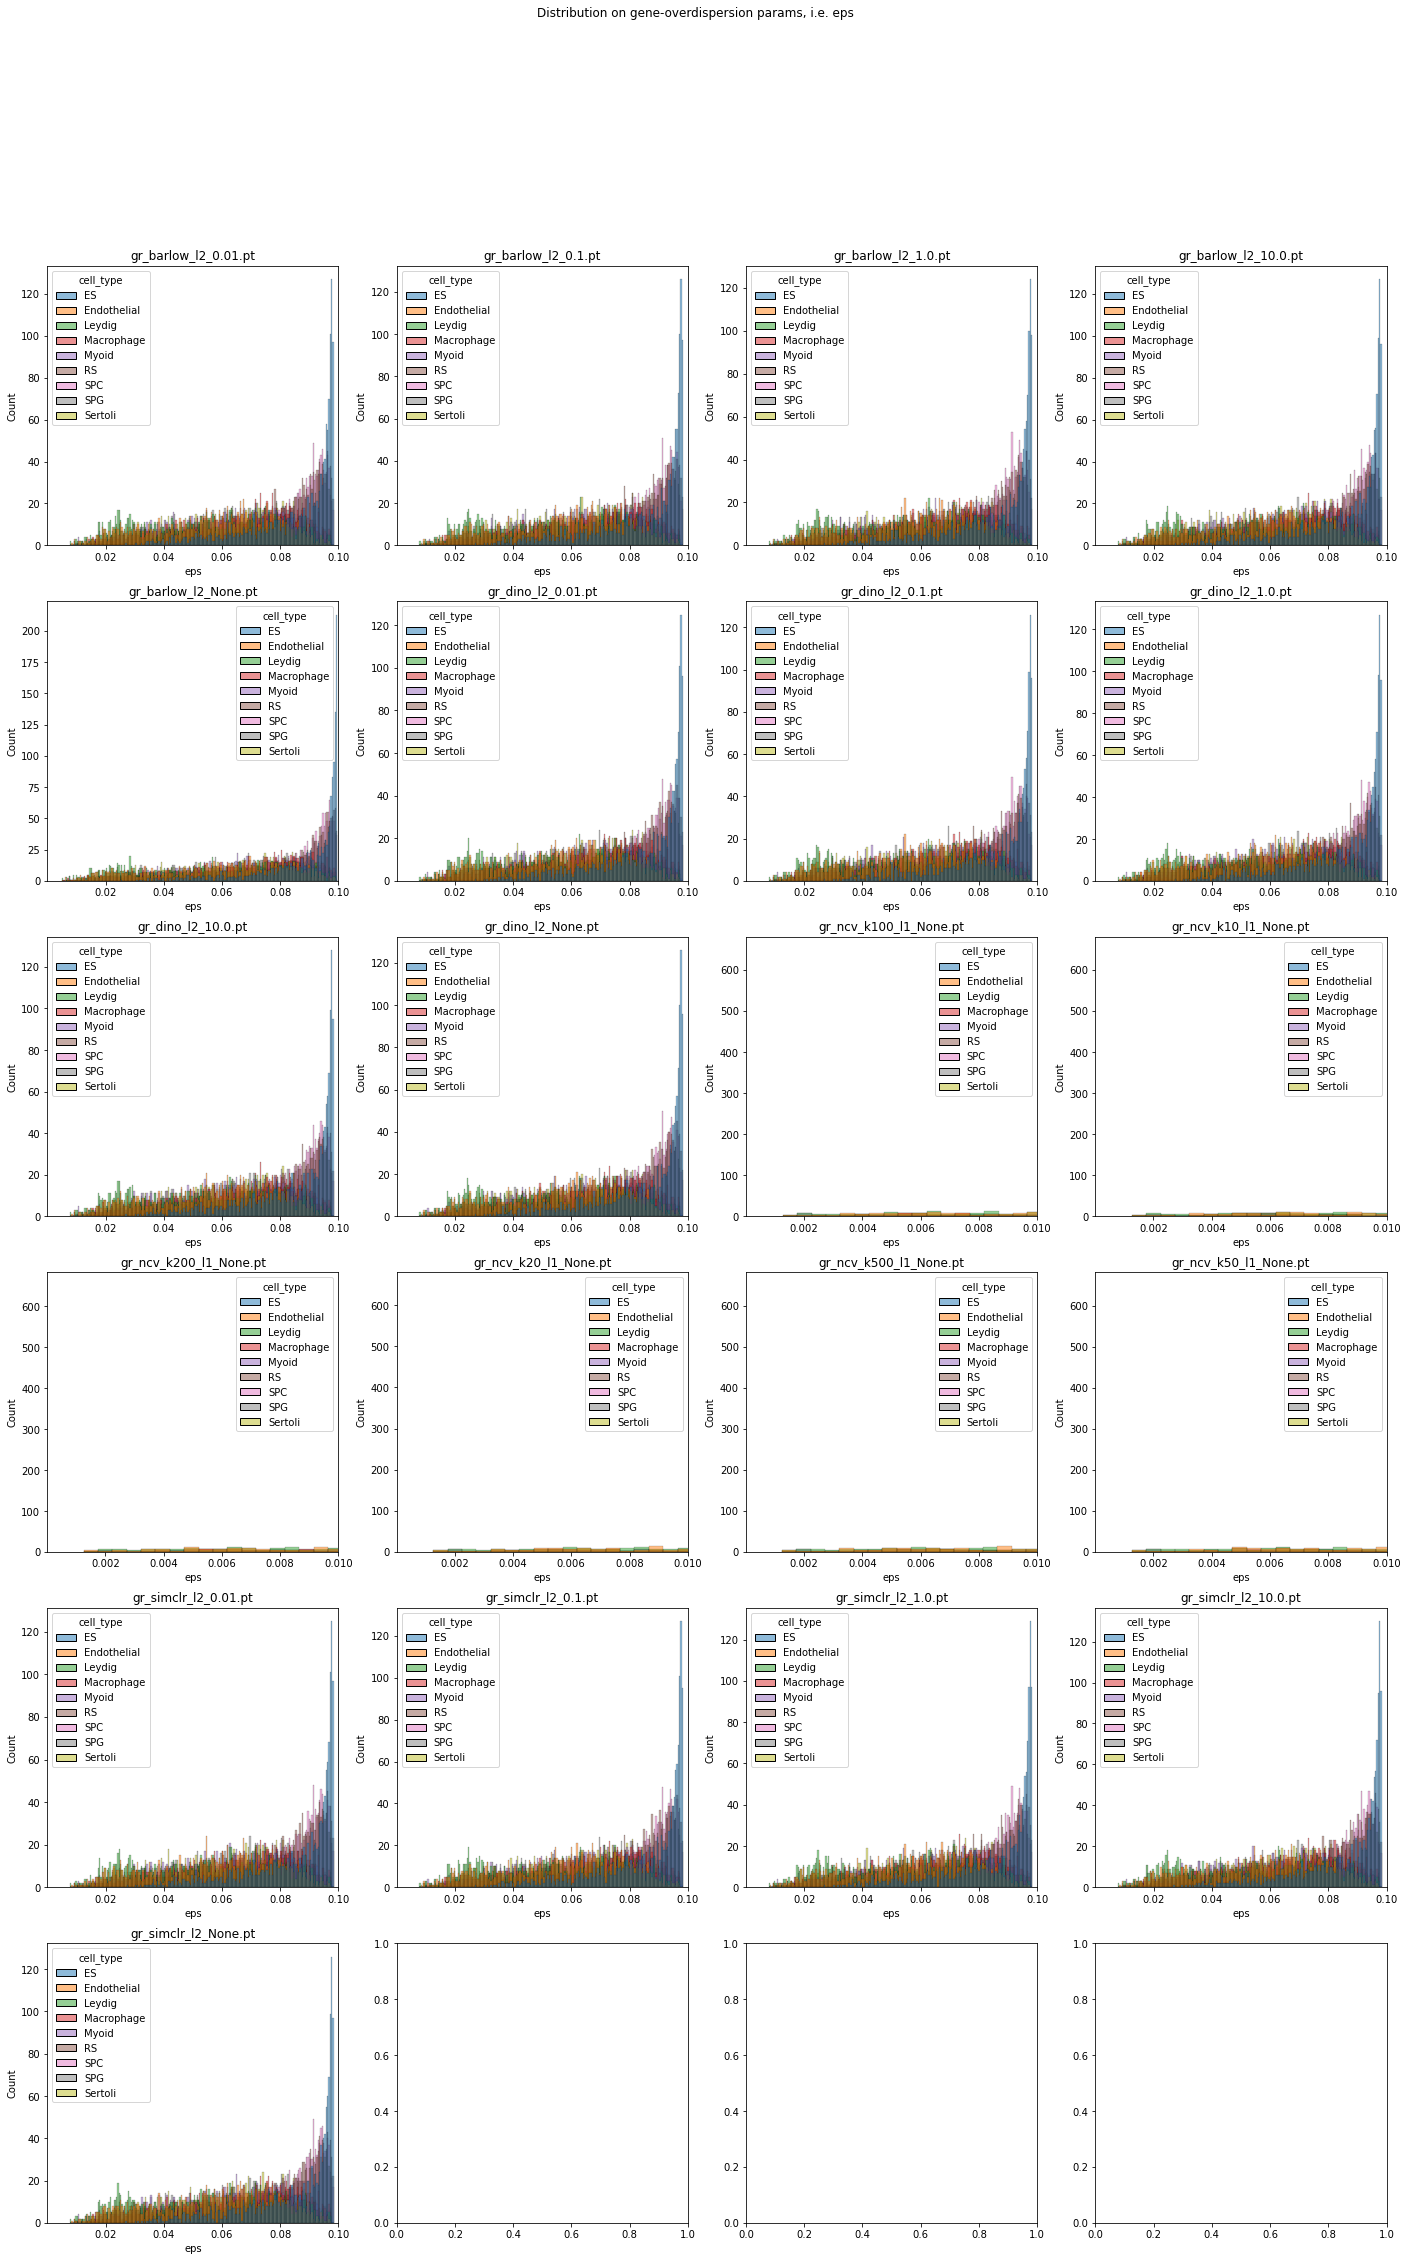

In [35]:
nmax = len(ckpt_list)
ncols = 4
nrows = int(numpy.ceil(float(nmax)/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 6*nrows))
fig.suptitle("Distribution on gene-overdispersion params, i.e. eps")


for n, ckpt_file in enumerate(ckpt_list):
    r,c = n//ncols, n%ncols
    ax_cur = axes[r,c]
    gr.load_ckpt(os.path.join(gr_ckpt_dir, ckpt_file))
    df_param = gr.get_params()
    
    _ = seaborn.histplot(data=df_param, x="eps", hue="cell_type", bins=200, ax=ax_cur, multiple="layer")
    _ = ax_cur.set_title(ckpt_file)
    _ = ax_cur.set_xlim(gr._train_kargs["eps_range"]) 

### Compute the baseline metrics (i.e. the case with no covariates).

In [38]:
filename_no_covariate_ckpt = os.path.join(gr_ckpt_dir, "gr_no_covariate.pt")
filename_no_covariate_dataset = os.path.join(gr_ckpt_dir, "gr_no_covariate_dataset.pt")

import torch
import seaborn

gr.load_ckpt(filename_no_covariate_ckpt)
train_dataset, test_dataset, val_dataset = torch.load(filename_no_covariate_dataset)

df_metric_no_cov_train, df_count_no_cov_train = gr.predict(
    test_dataset,
    num_samples=100,
    subsample_size_cells=200,
    subsample_size_genes=None)

df_metric_no_cov_test, df_count_no_cov_test = gr.predict(
    test_dataset,
    num_samples=100,
    subsample_size_cells=200,
    subsample_size_genes=None)

### plot the ratio of q_train_no_cov over q_test_no_cov

In [40]:
df_baseline_train["q_train_over_test"] = df_baseline_train["q_dist"] / df_baseline_test["q_dist"]

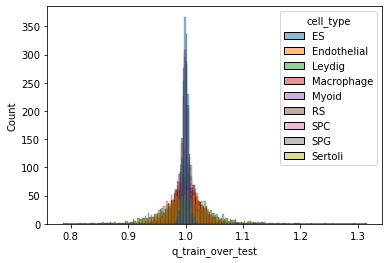

In [41]:
_ = seaborn.histplot(data=df_baseline_train, x="q_train_over_test", hue="cell_type", bins=200)
#_ = ax_cur.set_title("{} score= {}".format(ckpt_file, score))

### compute the ratio w.r.t the baseline

In [42]:
result_dict = dict()
for n, (data_file, ckpt_file) in enumerate(zip(dataset_list, ckpt_list)):

    gr.load_ckpt(os.path.join(gr_ckpt_dir, ckpt_file))
    train_dataset, test_dataset, _ = torch.load(os.path.join(gr_ckpt_dir, data_file))
    df_metric_tmp_train, df_count_tmp_train = gr.predict(
        train_dataset,
        num_samples=100,
        subsample_size_cells=200,
        subsample_size_genes=None)
    
    df_metric_tmp_test, df_count_tmp_test = gr.predict(
        test_dataset,
        num_samples=100,
        subsample_size_cells=200,
        subsample_size_genes=None)
    
    df_tmp_test = df_metric_tmp_test.groupby(["cell_type", "gene"]).mean()
    df_tmp_test["q_ratio"] = df_tmp_test["q_dist"] / df_baseline_test["q_dist"]
    result_dict["test_"+ckpt_file] = df_tmp_test 
    
    df_tmp_train = df_metric_tmp_train.groupby(["cell_type", "gene"]).mean()
    df_tmp_train["q_ratio"] = df_tmp_train["q_dist"] / df_baseline_train["q_dist"]
    result_dict["test_"+ckpt_file] = df_tmp_train 

KeyboardInterrupt: 

# plot the distribution of Q

gr_ncv_k100_l1_None.pt
gr_ncv_k10_l1_None.pt
gr_ncv_k200_l1_None.pt
gr_ncv_k20_l1_None.pt
gr_ncv_k500_l1_None.pt
gr_ncv_k50_l1_None.pt


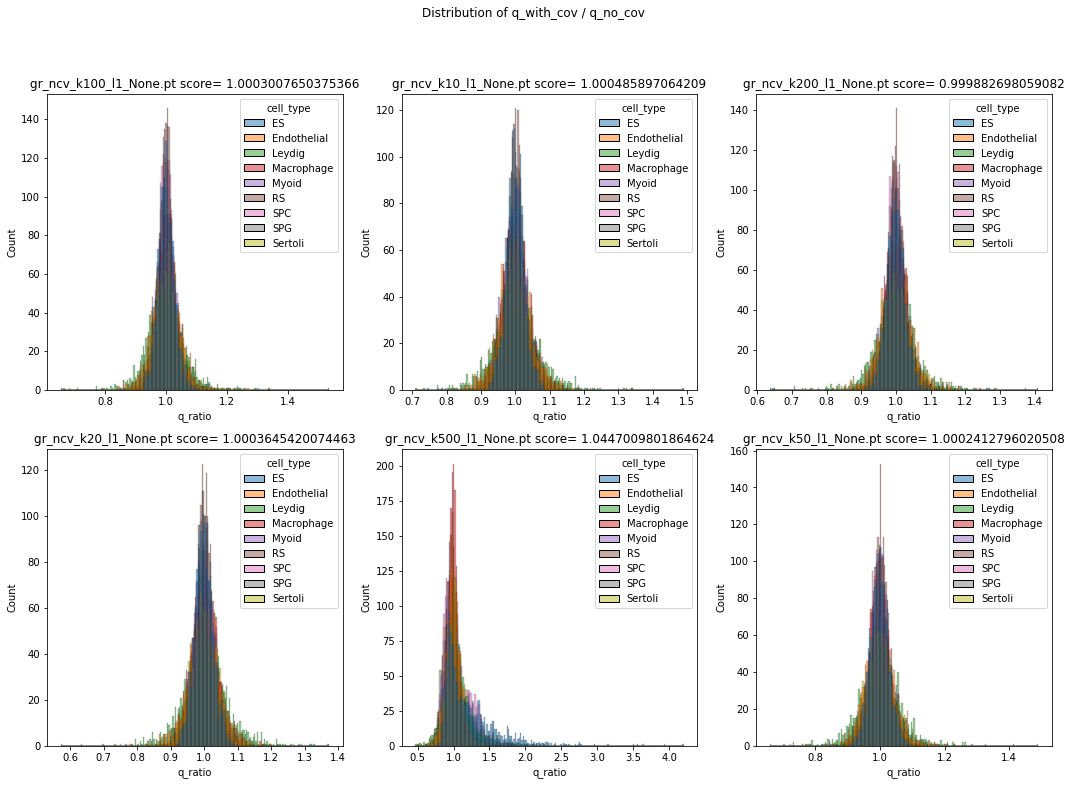

In [57]:
nmax = len(result_dict.keys())
ncols = 3
nrows = int(numpy.ceil(float(nmax)/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 6*nrows))
fig.suptitle("Distribution of q_with_cov / q_no_cov")
    
for n, key in enumerate(result_dict.keys()):
    print(key)
    r,c = n//ncols, n%ncols
    ax_cur = axes[r,c]
    
    
    _ = seaborn.histplot(data=result_dict[key], x="q_ratio", hue="cell_type", bins=200, ax=ax_cur)
    score = result_dict[key]["q_ratio"].mean()
    _ = ax_cur.set_title("{} score= {}".format(key, score))

From these plots I see that all ncv are roughly equivalent to predict gene expression. \
Maybe only some genes in some cell_type can be predicted using ncv. \
We explore this possibility below

# FROM HERE

### Find most predictable genes. Maybe only few genes can be predicted from micro-environment

In [60]:
for key in result_dict.keys():
    print(key)

gr_ncv_k100_l1_None.pt
gr_ncv_k10_l1_None.pt
gr_ncv_k200_l1_None.pt
gr_ncv_k20_l1_None.pt
gr_ncv_k500_l1_None.pt
gr_ncv_k50_l1_None.pt
